# Deep Learning (APPROF) - Convolutional Neural Network (CNN) Problem Resolution

## Team Members:

- Filip Orlikowski, 1242389
- Filippo Ianniello, 1242315
- Olivia Puig, 1242352

## Dataset Description:

The dataset used for this problem contains images of approximately 960 unique **plants** belonging to **12 species** at several growth stages.
The list of species is as follows:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Objective:

The objective of this problem is to develop a deep learning model, using a Convolutional Neural Network, aimed at classifying the various species of plant seedlings based on their images.

It is expected that the accuracy for each species, on average, exceeds 80%, and recall and precision must also be above 70%. Furthermore, the following questions, will be addressed during the model development:
- What is the impact of different filters, strides, padding, and pooling methods on the model's performance?
- What is the result of the convolution of a specific layer using example input images? What insights can be derived from it?
- What happens to the model performance when data agumentation is applied?
- Is there overfitting in the model? If yes how to solve it?
- What happens to the model results with and without a pre-trained network (e.g. Resnet50)?

## Solution:

In [7]:
# Standard libraries
import itertools
import json
import os
import random
import time
import zipfile

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import seaborn as sns

# Image processing
import cv2
from PIL import Image

# Notebook interaction
import nbformat as nb

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import class_weight

# TensorFlow / Keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling2D, Input, MaxPooling2D)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.utils import plot_model

# Kaggle API (to uncomment if we want to download datasets)
from kaggle.api.kaggle_api_extended import KaggleApi

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')
#base_dir= '/content/drive/MyDrive/Approf_Project/'
base_dir= './'

### Dataset Importing
To download the dataset we used the KaggleAPI. We created a **Kaggle api Token** and set it up by creating a .json file in the following path of our system: ~/.kaggle/kaggle.json
The kaggle.json file had to look like this:

```python
{
   "username": "your_username",
   "key": "your_key"
}

In [112]:
dataset_path = base_dir+'plant_seedlings'                     # Path to download the dataset
if not os.path.exists(dataset_path):
    if(not os.path.exists('kaggle.json')):
        print("Please place your kaggle.json file in the current directory.")
        exit()

    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()

    competition_name = 'plant-seedlings-classification'     # Name of the Kaggle competition

    # Download the competition dataset
    api.competition_download_files(competition_name, path=dataset_path)
    print(f"Dataset downloaded to {dataset_path}")

    # Unzip the dataset downloaded
    with zipfile.ZipFile(f'{dataset_path}/{competition_name}.zip', 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

    print("Dataset extracted.")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ./plant_seedlings


### Dataset Exploration

The dataset downloaded had the following folders:
- train, that contained the training set, with plant species organized by folder
- test, that contained the test set of images to predict

*Note*: we considered as our entire dataset only the samples that were in the train folder. The samples in the test folder weren't labelled, so not useful neither for training nor for testing.

In [113]:
train_dir = base_dir+"plant_seedlings/train"
#test_dir = base_dir+"plant_seedlings/test"

Before exploring the dataset we checked if there were **corrupted** or **unreadable** images inside the folders.
To quickly check whether an image file is corrupted, without fully decoding or loading the image data into memory, we used the *verify()* function in the Pillow (PIL) library. It detects things like truncated files, unexpected end of file, malformed headers, corrupted compression blocks.

In [114]:
def check_corrupted_images(dir_to_check):
    """
    Check for corrupted or unreadable images in a given directory.
    """
    corrupted_images = []
    for img_name in os.listdir(dir_to_check):
        img_path = os.path.join(dir_to_check, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()                    # Lightweight corruption check
        except Exception as e:
            corrupted_images.append(img_path)
            print(f"Error opening {img_path}: {e}")
    return corrupted_images

# Check for corrupted images in the training set
train_corrupted_images = []
for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    if os.path.isdir(cls_dir):
        print(f"Checking images in class: {cls}")
        train_corrupted_images.extend(check_corrupted_images(cls_dir))

print(f"\nFound {len(train_corrupted_images)} corrupted or unreadable images.")
for img in train_corrupted_images:
    print(img)

Checking images in class: Cleavers
Checking images in class: Sugar beet
Checking images in class: Common Chickweed
Checking images in class: Loose Silky-bent
Checking images in class: Scentless Mayweed
Checking images in class: Shepherds Purse
Checking images in class: Fat Hen
Checking images in class: Common wheat
Checking images in class: Black-grass
Checking images in class: Small-flowered Cranesbill
Checking images in class: Charlock
Checking images in class: Maize

Found 0 corrupted or unreadable images.


#### Class Distribution Analysis:
As first operation in exploring the dataset, we examined the distribution of samples across the different classes. This analysis is essential to determine if the dataset is balanced or exhibit class imbalance.

We found that the most frequent class ("Loose Silky-bent") has around 650 images, while the least frequent ("Maize") has a bit more than 200. So the most represented class contains nearly three times as many samples as the least represented one. While not extreme, this imbalance may influence model performance.

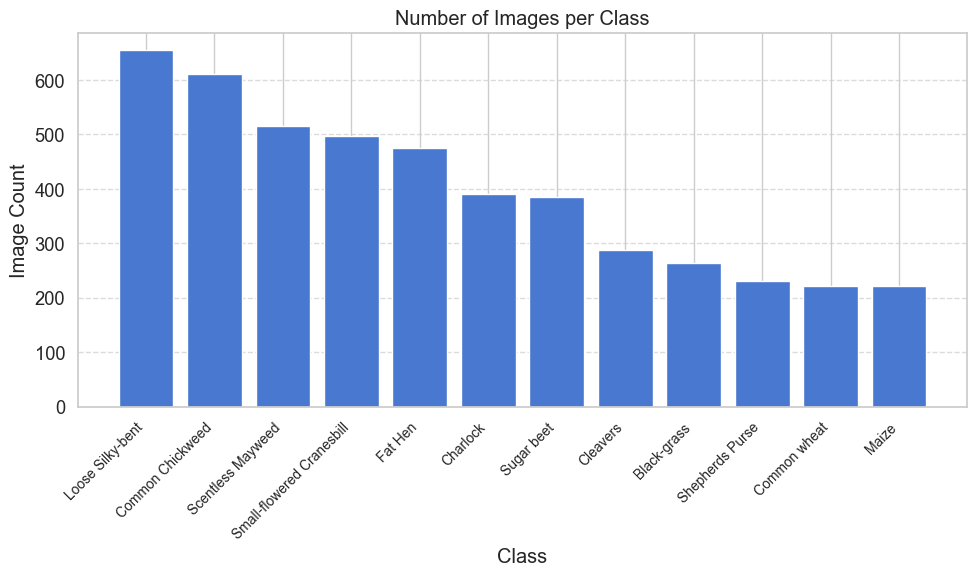

In [115]:
# Get list of subdirectories (classes) and count images
class_counts = {}
for cls_name in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls_name)
    if os.path.isdir(cls_path):
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        class_counts[cls_name] = len(image_files)

# Create DataFrame and sort by count
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_counts.sort_values(by='Image Count', ascending=False, inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_counts['Class'], df_counts['Image Count'])
ax.set_title("Number of Images per Class")
ax.set_xlabel("Class")
ax.set_ylabel("Image Count")
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Images Exploration per Class
As second operation, we wanted to understand how these different species of plant seeding looked like. Thus, for each class of the dataset, we visualized one random image of the training set that represented that class. We used *Plotly*, in order to have an **interactive output** where we can zoom, pan, and resize the view of the images.

In [116]:
# Get class names
class_names = df_counts['Class'].tolist()

# Grid size (customize as needed)
n_rows, n_cols = 3, 4
max_images = n_rows * n_cols

# Initialize Plotly subplot figure
fig = sp.make_subplots(rows=n_rows, cols=n_cols,
                       subplot_titles=class_names[:max_images],
                       vertical_spacing=0.05, horizontal_spacing=0.03)

# Load and add images
img_idx = 0
for row in range(1, n_rows + 1):
    for col in range(1, n_cols + 1):
        if img_idx >= len(class_names):
            break
        cls = class_names[img_idx]
        cls_path = os.path.join(train_dir, cls)
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        if image_files:
            img_file = random.choice(image_files)
            img_path = os.path.join(cls_path, img_file)
            try:
                with Image.open(img_path) as img:
                    fig.add_trace(
                        go.Image(z=img),
                        row=row, col=col
                    )
            except Exception as e:
                print(f"Error loading image: {img_path} ({e})")
        img_idx += 1

# Update layout for cleaner visuals
fig.update_layout(
    height=800, width=1200,
    title_text="Example Images from Each Class (Interactive)",
    showlegend=False,
    title_x=0.5,
    margin=dict(l=10, r=10, t=60, b=10)
)

# Remove axes for all subplots
for i in range(1, n_rows * n_cols + 1):
    fig['layout'][f'xaxis{i}']['visible'] = False
    fig['layout'][f'yaxis{i}']['visible'] = False

fig.show()


#### Images Color Modes Check:
We inspected all images and tried to classify them into three types: true grayscale images (mode 'L'), pseudo-grayscale images (RGB images where R ≈ G ≈ B), and fully colored RGB images.
It's important to understand the color mode of the images for a CNN for preprocessing decision or as well for the Input Consistency (wheter to have 1 or 3 channels as input).

In [117]:
def classify_image_color_mode(directory):
    """
    Classify valid images as RGB, grayscale, or pseudo-grayscale.
    """
    grayscale_L = []
    pseudo_grayscale = []
    rgb_images = []

    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                if img.mode == 'L':                     # Check if the image is in grayscale mode 'L'
                    grayscale_L.append(img_path)
                else:
                    img_rgb = img.convert('RGB')
                    np_img = np.array(img_rgb)

                    # Check if R, G, B channels are nearly equal (pseudo-grayscale)
                    if np.allclose(np_img[..., 0], np_img[..., 1], atol=2) and \
                       np.allclose(np_img[..., 1], np_img[..., 2], atol=2):
                        pseudo_grayscale.append(img_path)
                    else:
                        rgb_images.append(img_path)
        except Exception as e:
            print(f"Unexpected read error: {img_path} ({e})")
            continue

    return grayscale_L, pseudo_grayscale, rgb_images

train_grayscale_L = []
train_pseudo_gray = []
train_rgb = []

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)

    if os.path.isdir(cls_path):
        gL, pg, rgb = classify_image_color_mode(cls_path)
        train_grayscale_L.extend(gL)
        train_pseudo_gray.extend(pg)
        train_rgb.extend(rgb)

print(f"Grayscale (mode 'L'): {len(train_grayscale_L)}")
print(f"Pseudo-grayscale (RGB but R=G=B): {len(train_pseudo_gray)}")
print(f"Fully colored RGB images: {len(train_rgb)}")

Grayscale (mode 'L'): 0
Pseudo-grayscale (RGB but R=G=B): 0
Fully colored RGB images: 4750


We found out that all the images were Fully colored RGB. So we then proceeded with the RGB analysis of the images.

#### RGB Channel Statistics
We analyzed the color characteristics (RGB) of all images in our training dataset. We examined the color distribution across all images by computing the **mean**, **standard deviation**, and **correlations** of the RGB channels. Finally, we plotted the **RGB Channel Mean Distribution**, in order to have some insight on the overall color balance of our dataset. This is helpful for preprocessing decision or to detect color bias.

*Note*: to make the data more interpretable and visually consistent, we normalized the RGB values of the images before the analysis

Mean values per channel:
R    0.328815
G    0.289346
B    0.207304
dtype: float64
Standard deviation per channel:
R    0.034725
G    0.037108
B    0.050703
dtype: float64
Correlation between RGB channels:
          R         G         B
R  1.000000  0.882091  0.764380
G  0.882091  1.000000  0.858662
B  0.764380  0.858662  1.000000


<Figure size 1000x600 with 0 Axes>

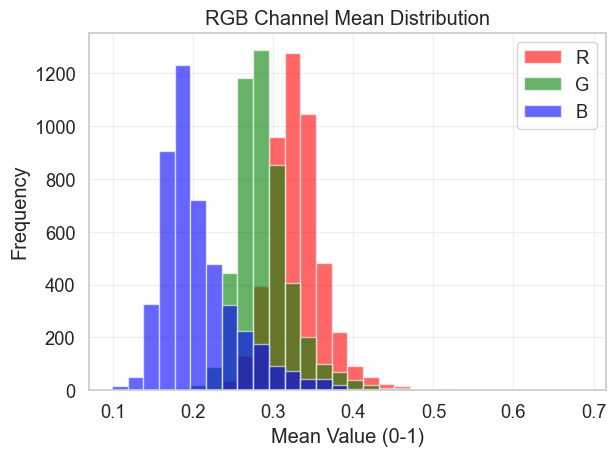

In [118]:
# Function to compute RGB means
def compute_rgb_means(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img) / 255.0                  # Normalize pixel values to [0, 1]
        r_mean = np.mean(img_np[:, :, 0])
        g_mean = np.mean(img_np[:, :, 1])
        b_mean = np.mean(img_np[:, :, 2])
        return r_mean, g_mean, b_mean
    except:
        return None

# Collect the RGB means for all images
rgb_means = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        means = compute_rgb_means(img_path)
        if means:
            rgb_means.append(means)

# Convert to DataFrame
df_rgb = pd.DataFrame(rgb_means, columns=['R', 'G', 'B'])

# Check the mean and std dev of each color channel
mean_rgb = df_rgb.mean()
std_rgb = df_rgb.std()

print(f"Mean values per channel:\n{mean_rgb}")
print(f"Standard deviation per channel:\n{std_rgb}")

# Check correlations between channels (to see if any channel is too similar or too different)
correlation_matrix = df_rgb.corr()
print(f"Correlation between RGB channels:\n{correlation_matrix}")

# Plot histograms of R, G, B with matching colors
plt.figure(figsize=(10, 6))
df_rgb.plot(kind='hist', bins=30, alpha=0.6, color=['red', 'green', 'blue'])
plt.title('RGB Channel Mean Distribution')
plt.xlabel("Mean Value (0-1)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

From the graph we see that we should not encounter grayscale pictures. RGB colors are **distinclty distributed** with red channel resulting in the dominating color, with a mean value of 0.32, then we have green (presumably the plants color) with 0.29 and blue 0.21 which is a minority among the rgb set of colors.

#### Images Dimension Distribution
We analyzed and visualized the sizes (width and height) of all images in a training dataset. Specifically we scanned all images in our training set, and recorded their dimensions. Then we visualized their distribution of widths and heights using histograms. This is useful mainly for spotting outliers or to decide the resize strategies for the preprocessing.

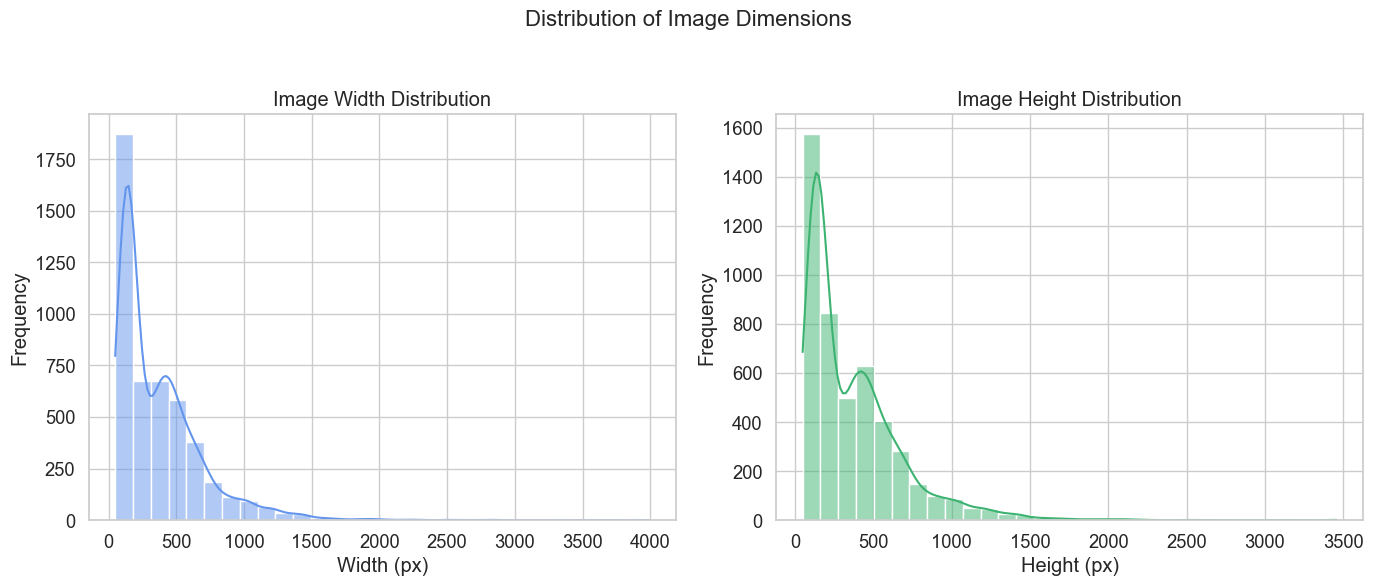

In [119]:
# Set Seaborn theme for cleaner aesthetics
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

def collect_image_shapes(directory):
    """
    Collect the dimensions of images in a directory and return a list of tuples (width, height).
    """
    shapes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    shapes.append(img.size)                 # Tuple (width, height)
            except Exception as e:
                print(f"Could not open image: {image_path} ({e})")
    return shapes

# Collect image dimensions and create DataFrame
image_shapes = collect_image_shapes(train_dir)
df_shapes = pd.DataFrame(image_shapes, columns=['width', 'height'])

# Create figure with Seaborn plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df_shapes, x='width', bins=30, ax=axs[0], kde=True, color='cornflowerblue')
axs[0].set_title('Image Width Distribution')
axs[0].set_xlabel('Width (px)')
axs[0].set_ylabel('Frequency')

sns.histplot(data=df_shapes, x='height', bins=30, ax=axs[1], kde=True, color='mediumseagreen')
axs[1].set_title('Image Height Distribution')
axs[1].set_xlabel('Height (px)')
axs[1].set_ylabel('Frequency')

plt.suptitle('Distribution of Image Dimensions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Histograms show that most images range from 100 to 600 pixels in width and height, with a few large outliers exceeding 1500 pixels. This **size variability** suggests that resizing or normalization is needed before using the data in the CNN.

#### Aspect Ratio Distribution of Images
We then visualized the distribution of aspect ratios (width divided by height) for the dataset of images.
(We included in the visualization also the kernel density estimate, KDE curve, to show the shape of the distribution)

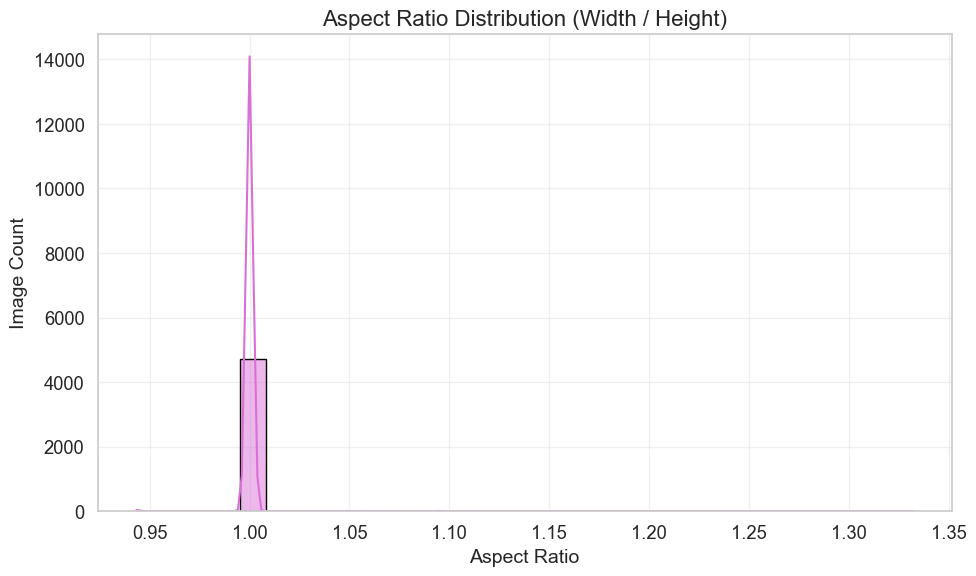

In [120]:
# Calculate Aspect Ratio
df_shapes['aspect_ratio'] = df_shapes['width'] / df_shapes['height']

# Set Seaborn style for improved visuals
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))

# Plot histogram of aspect ratios (with KDE)
sns.histplot(df_shapes['aspect_ratio'], bins=30, color='orchid', kde=True, edgecolor='black')

# Customize plot with titles and labels
plt.title("Aspect Ratio Distribution (Width / Height)", fontsize=16)
plt.xlabel("Aspect Ratio", fontsize=14)
plt.ylabel("Image Count", fontsize=14)

# Show grid with a soft transparency
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#print(df_shapes['aspect_ratio'].value_counts())

The significant majority of the images have an aspect ratio close to 1, meaning that most of the images are square or nearly square. So, knowing that the dataset primarily consists of square images, it is okay to standardize all images to a square resolution when preprocessing. Indeed, since the original shapes are already close to square, resizing them uniformly **is unlikely to distort the visual content**.

### Dataset Preprocessing
Before building and training the CNN model, we applied some preprocessing operations on the dataset in order to prepare in the best way the inputs for the Neural Network.

#### Image Conversion and Resizing
The first two operation we did were:
- **Converting** the images in 3 channels RGB because we saw that all the pictures were fully colored RGB.
- **Resizing** the images to a fixed shape (in our case 96×96 pixels) because CNNs require inputs of *consistent spatial dimensions* in order to build a structured tensor flow through the network layers. Even if our images had more pixels. The reasons why we chose the resolution 96×96 are mainly to ensure a faster training and to lower the risk of overfitting. Indeed higher-resolution images increases the number of trainable parameters in the model, which in turn raises the risk of overfitting (if the dataset isn't large enough). While lower resolutions can act as a form of regularization.
- **Mapping** images with the labels: we created the mapping between the images (X) converted and resized in array and the labels.

In [ ]:
# Parameters
img_size = 96

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)

    for filename in os.listdir(class_dir):
        if filename.startswith('.'):
            continue
        img_path = os.path.join(class_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")   # Open image, convert to RGB

            img = img.resize((img_size, img_size))      # Resize image to 96x96 pixels

            img_array = img_to_array(img)               # Convert PIL image to array

            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# After this operation, we have our images and labels ready
# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")

Images loaded and resized
Image shape: (4750, 96, 96, 3)
Unique classes: 12


#### Images Preprocessing Pipeline
To enhance model performance in our task of object recognition, we built a pipeline to ensure that the images are cleaned, standardized, and focused on the desired features (in our case green areas because we want to classify plants)
Specifically, the preprocessing opeartions done are:
1. **Gaussian Blurring**, in order to reduce *high-frequency noise* and small irregularities. This helps in a better segmentation in the next steps, because it make easier to isolate meaningful shapes like leaves or stems (in our case).
2. **Green Masking**, that isolates plant regions (assuming leaves are green). Everything outside this range (background) will be ignored. We considered specific lower and upper HSV (Hue Saturation Value) values for the green mask to accurately segment plant regions.
3. **Morphological Filtering** that smooths the mask by removing specks of noise and filling small holes/gaps within green areas.
4. **Normalization** of the pixel values to the range [0, 1] by dividing each pixel value by 255. We did this in order to helps improve training stability and to reduce the risk of *exploding gradients* during backpropagation.
5. **Sharpening** that makes fine details more prominent, helping the CNN better learn structural features that distinguish plant species.

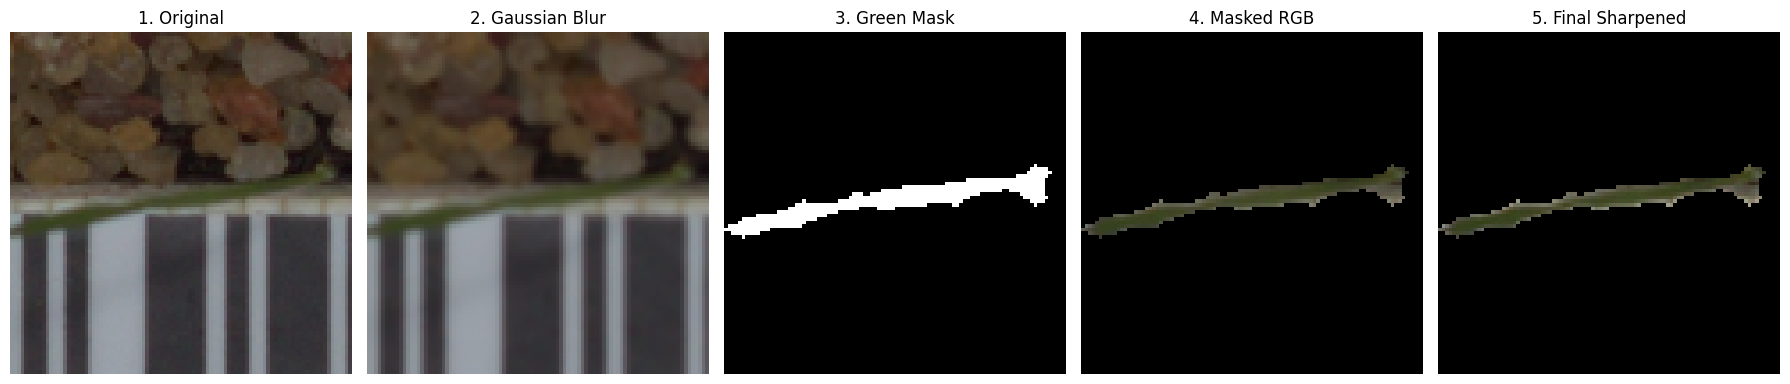

In [ ]:
# --- Sharpening function using unsharp masking ---
def sharpen_image(img):
    # Apply a Gaussian blur to create a blurred version of the image
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    # Sharpening by subtracting the blurred image from the original
    sharpened = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    return sharpened

# --- Preprocessing function ---
def preprocess_image(img_original, print_steps=False):
    """
    The input is:
    - img_original: Numpy array of shape (height, width, 3) with images in RGB format. So all images are expected
    to be in RGB format and to have the same dimensions (height x width).
    - print_steps: Boolean flag to control whether to print the preprocessing steps or not.

    Output:
    - final_img: Numpy array of shape (height, width, 3)
    """
    # --- Configuration Settings for the preprocessing ---
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

    # Converting values to uint8, because *OpenCV* functions
    # expect images in uint8 format with 0–255 pixel intensity.
    img_uint8 = img_original.astype(np.uint8)

    Gblur_img = cv2.GaussianBlur(img_uint8, (3, 3), 0)              # 1. Gaussian blurring

    # Color Space Conversion from RGB to HSV (Hue Saturation Value):
    # HSV is better for color-based segmentation, so green colors can be isolated
    # more easily by their hue, regardless of lighting.
    hsv_img = cv2.cvtColor(Gblur_img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_img, lower_green, upper_green)           # 2. Green masking

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)          # 3. Morphological filtering

    # Boolean Mask that converts the binary mask to a boolean array. Makes it easy to
    # index into the image and apply the mask. Only pixels that are True (i.e., green areas) will be kept.
    bMask = mask > 0

    # Apply Mask, that creates a new image with only the plant parts, while everything else will be black.
    clearImg = np.zeros_like(img_uint8, np.uint8)
    clearImg[bMask] = img_uint8[bMask]

    clearImg_float = clearImg.astype(np.float32) / 255.0            # 4. Normalization of pixel values

    final_img = sharpen_image(clearImg_float)                       # 5. Sharpening of the image

    if print_steps:
        images = [
            ("1. Original", img_uint8),
            ("2. Gaussian Blur", Gblur_img),
            ("3. Green Mask", mask),
            ("4. Masked RGB", clearImg),
            ("5. Final Sharpened", final_img)
        ]

        fig, axes = plt.subplots(1, len(images), figsize=(18, 4))
        for ax, (title, img) in zip(axes, images):
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.set_title(title); ax.axis('off')
        plt.tight_layout(); plt.show()

    return final_img

# Example of a preprocessed image
adfa = preprocess_image(X[0], print_steps=True)

In [ ]:
# Preprocess all the images in the dataset
X_preprocessed = []
for img in X:
    preprocess_image(img)  # Preprocess each image in the dataset
    X_preprocessed.append(preprocess_image(img))

X = np.array(X_preprocessed)

print("Preprocessing of the dataset complete.")

print("Saving the preprocessed dataset to the disk...")
np.savez_compressed(base_dir+'plant_seedlings_preprocessed.npz', images=X, labels=y)
print("Preprocessed dataset saved as 'plant_seedlings_preprocessed.npz'.")


Preprocessing of the dataset complete.
Saving the preprocessed dataset to the disk...
Preprocessed dataset saved as 'plant_seedlings_preprocessed.npz'.


In [9]:
# Loading the preprocessed dataset
data = np.load(base_dir+'plant_seedlings_preprocessed.npz')
X = data['images']
y = data['labels']

#### Label Encoding
To prepare the input for the Neural Network we first performed the **Label Encoding**, which consists of converting the labels, associated with each sample in the dataset, into integers. Each integer is identifying a specific classification category.
Then we did the **One-hot Encoding**, which converts the class labels in *binary vectors*. This is an important operation to make sure the labels values to match with the output format of the neural network.

In [10]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping of labels to integers
print("Label encoding mapping:")
for label, index in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{label} = {index}")

y_encoded_reshaped = y_encoded.reshape(-1, 1)               # OneHotEncoder needs 2D input
onehot_encoder = OneHotEncoder(sparse_output=False)
y_one_hot = onehot_encoder.fit_transform(y_encoded_reshaped)

# Print in series 5 original, encoded, and one-hot encoded labels (randomly selected)
print("\nSample of original, encoded, and one-hot encoded labels:")
for i in random.sample(range(len(y)), 5):
    print(f"Original: {y[i]}, Encoded: {y_encoded[i]}, One-hot: {y_one_hot[i]}")

Label encoding mapping:
Black-grass = 0
Charlock = 1
Cleavers = 2
Common Chickweed = 3
Common wheat = 4
Fat Hen = 5
Loose Silky-bent = 6
Maize = 7
Scentless Mayweed = 8
Shepherds Purse = 9
Small-flowered Cranesbill = 10
Sugar beet = 11

Sample of original, encoded, and one-hot encoded labels:
Original: Loose Silky-bent, Encoded: 6, One-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original: Common wheat, Encoded: 4, One-hot: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original: Cleavers, Encoded: 2, One-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original: Loose Silky-bent, Encoded: 6, One-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original: Common Chickweed, Encoded: 3, One-hot: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Dataset Splitting
The dataset was splitted with the following percentages:
- 70% Train Set
- 15% Validation Set
- 15% Test Set

The stratify option in the *train_test_split()* ensures that the class distribution is preserved in the splits. So training, validation and test set will have the same class distribution.

Data splitting completed.
X_train shape: (3325, 96, 96, 3)
y_train shape: (3325, 12)
X_val shape:   (712, 96, 96, 3)
y_val shape:   (712, 12)
X_test shape:  (713, 96, 96, 3)
y_test shape:  (713, 12)

Printing one training sample:
Image shape: (96, 96, 3), Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


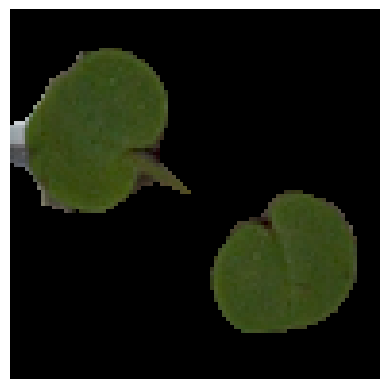

In [11]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp, y_train_enc, y_temp_enc = train_test_split(
    X, y_one_hot, y_encoded, test_size=0.30, stratify=y_encoded, random_state=42
)

# Second split: Validation (15%) and Test (15%) from Temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp_enc, random_state=42
)

print("Data splitting completed.")
print(f"X_train shape: {X_train.shape}"); print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}"); print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}"); print(f"y_test shape:  {y_test.shape}")

print(f"\nPrinting one training sample:")
print(f"Image shape: {X_train[0].shape}, Label: {y_train[0]}")
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

### Convolutional Neural Network Development

Once preprocessed the dataset, we started addressing the requirements of the project by developing a **Convolutional Neural Network** able to classify the plant seedings.

#### CNN Useful Function

##### Model Builder Function
To investigate the impact of different architectural choices on CNNs, we implemented a flexible **CNN builder function**. This function allows us to dynamically configure and build CNN models by adjusting some parameters, such as the number of filters, pooling strategy, stride, use of batch normalization, dropout rate, exc.
(In this way we eliminated the need to repeatedly write the same code for instanciating the CNN model).

In [9]:
def build_custom_cnn(
    input_shape,                        # Input shape of the images, (height, width, channels)
    num_classes,                        # Number of classes/categories in the dataset
    # Convolutional layers Parameters
    filters=[32, 64, 128],         # List of filters for Conv layers, usually powers of 2,e.g. [64, 128, 256]
    kernel_size=(3, 3),                 # Kernel size for Conv layers, usually (3, 3) or (5, 5)
    conv_activation='relu',             # Activation function for Conv2D layers, usually 'relu', 'tanh', etc.
    padding='same',                     # Padding for Conv2D layers, usually 'same' or 'valid'
    # Pooling Parameters
    pooling='max',                      # Pooling type, 'max' for MaxPooling2D or 'avg' for AveragePooling2D
    pool_size=(2, 2),                   # Pooling size, usually (2, 2) or (3, 3)
    pool_stride=2,                      # Stride for pooling, usually 2, 3, or None
    use_batchnorm=True,                 # Whether to use Batch Normalization after Conv layers
    # Dense layers Parameters
    dense_layers=[512, 256, 128],       # Dense layers configuration, usually powers of 2, e.g., [512, 256, 128]
    dense_activation='relu',            # Activation function for Dense layers, usually 'relu', 'tanh', etc.
    dropout_rate=0.3,                   # Dropout rate, usually between 0.2 and 0.5
    final_activation='softmax'          # ActFunction for the output layer,'softmax' for multi-class classification
):
    model = Sequential()

    # Input layer
    model.add(Input(shape=input_shape))

    # Convolutional and Pooling layers configuration
    for f in filters:
        model.add(Conv2D(f, kernel_size, activation=conv_activation, padding=padding))
        if use_batchnorm:                               # Adding batch Normalization if specified
            model.add(BatchNormalization())

        # Add pooling layer if specified
        if pooling == 'max':
            model.add(MaxPooling2D(pool_size=pool_size, strides=pool_stride))
        elif pooling == 'avg':
            model.add(AveragePooling2D(pool_size=pool_size, strides=pool_stride))

    # Flatten Layer
    model.add(Flatten())

    # Dense layers configuration
    for units in dense_layers:
        if use_batchnorm:                                           # Adding Batch nrmalization
            model.add(BatchNormalization())
        model.add(Dense(units, activation=dense_activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation=final_activation))      # Output layer with softmax activation
    return model

##### Model Evaluation Printing Function
To prevent redundant code repetition, we defined two helper functions that prints out the three main aspects for evaluating a Classifier Neural Network, that are:
- Learning Curves, that take track of the model’s training and validation loss and accuracy over the epochs
- Classification Report, the summary of performance metrics with the precision, recall and F1-score for each class.
- Confusion Matrix, the tabular representation of true and predicted labels.

In [10]:
def print_learning_curves(history):
  metrics = {
      'Accuracy': ('accuracy', 'val_accuracy'),
      'Loss': ('loss', 'val_loss')
  }

  plt.figure(figsize=(12, 4))

  for i, (title, (train_key, val_key)) in enumerate(metrics.items(), 1):
      plt.subplot(1, 2, i)
      plt.plot(history[train_key], 'bo-', label='Training')
      plt.plot(history[val_key], 'ro--', label='Validation')
      plt.title(f'Training and Validation {title}')
      plt.xlabel('Epoch')
      plt.ylabel(title)
      plt.legend()
      plt.grid(True)

  plt.tight_layout()
  plt.show()

In [11]:
def print_classification_report_and_matrix(model, X_test=X_test, y_test=y_test, save_path=None):
    # Predict probabilities or logits
    y_pred_prob = model.predict(X_test)

    # Convert predictions to class indices
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert one-hot test labels to class indices
    y_true = np.argmax(y_test, axis=1)

    # Decode integer labels back to original class names
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_true)

    # Generate and print classification report
    report = classification_report(y_true_labels, y_pred_labels, digits=4, output_dict=True)
    print(classification_report(y_true_labels, y_pred_labels, digits=4))

    # Generate confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    # Save report and confusion matrix if save_path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Save classification report
        report_path = f"{save_path}_report.json"
        with open(report_path, "w") as f:
            json.dump(report, f, indent=4)

        # Save confusion matrix plot
        cm_path = f"{save_path}_confusion_matrix.png"
        plt.savefig(cm_path)

    plt.show()

#### Impact of different CNNs Configurations:
With the function defined above, we then examined the **impact** of different filters, strides, padding, and pooling techniques on the performance of the model.

##### Definition of CNNs Variants
We defined a set of different CNNs variants, each modifying a specific parameter of the base CNN configuration. Specifically, the variants individuated are:
- **More Filters** that use an extra convolutional layers with an increased filter depth (channels).
- **Larger Stride** that increase the pooling stride, so reducing the spatial dimensions
- **Valid Padding** that doesn't apply the 'same' padding strategy, so it won't reduce the feature map size.
- **Average Pooling** that use the average pooling instead of the max pooling of the default configuration.

Each of these variants was used to construct a separate CNN model. To **maintain consistency** across experiments, all models were compiled with the Adam optimizer and trained with the same batch, number of epochs and Callbacks that are:
- *EarlyStopping*, to stop the training if the validation loss didn't improve for three consecutive epochs. This could help to *prevent overfitting*.
- *ReduceLROnPlateau*: to dynamically lower the learning rate if the model plateaued during training, in order to facilitate a better convergence.

In [ ]:
# Define CNN variants with different parameters
cnn_variants_params = {
    'Original': {},
    'More_Filters': {'filters': [32, 64, 128, 256]},
    'Larger_Stride': {'pool_stride': 3},
    'Valid_Padding': {'padding': 'valid'},
    'Average_Pooling': {'pooling': 'avg'},
    # 'No_Dropout': {'dropout_rate': 0.0},
    # 'Deeper_Dense': {'dense_layers': [1024, 512, 256, 128]},
}

models = {}
results = {}
training_times = {}

# Directories to save models and histories
base_model_dir = base_dir + 'models'
base_history_dir = base_dir + 'histories'
os.makedirs(base_model_dir, exist_ok=True)
os.makedirs(base_history_dir, exist_ok=True)

# Load training times if they exist
training_times_path = os.path.join(base_dir, 'training_times.json')
if os.path.exists(training_times_path):
    with open(training_times_path, 'r') as f:
        training_times = json.load(f)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Testing the CNN variants and saving the models and results
for name, params in cnn_variants_params.items():
    print(f"\nProcessing model: {name}")

    model_path = os.path.join(base_model_dir, f"{name}.h5")
    history_path = os.path.join(base_history_dir, f"history_{name}.json")

    # Build and compile model
    print(f"Building model: {name}")
    model = build_custom_cnn(
        input_shape=X_train.shape[1:],  # (height, width, channels)
        num_classes=y_train.shape[1],   # Number of one-hot encoded labels
        **params
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=8,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Save model and training artifacts
    model.save(model_path)
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

    training_times[name] = elapsed_time
    print(f"Training time for {name}: {elapsed_time:.2f} seconds")
    print(f"Model saved to {model_path}")

    # Update in-memory results
    models[name] = model
    results[name] = history.history

# Save updated training times
with open(training_times_path, 'w') as f:
    json.dump(training_times, f)


Processing model: Original
Building model: Original
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.1888 - loss: 2.5712 - val_accuracy: 0.1376 - val_loss: 3.7797 - learning_rate: 0.0010
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3090 - loss: 1.9989 - val_accuracy: 0.5281 - val_loss: 1.4387 - learning_rate: 0.0010
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4029 - loss: 1.7333 - val_accuracy: 0.4508 - val_loss: 1.5868 - learning_rate: 0.0010
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4140 - loss: 1.6072 - val_accuracy: 0.5520 - val_loss: 1.2403 - learning_rate: 0.0010
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4767 - loss: 1.5408 - val_accuracy: 0.2697 - val_loss: 3.2477 - learning_rate: 0.0010
Epoch 6/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5089 - loss: 1.4258 - val_accuracy: 0.6559 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 7/15
416/416 ━━━━━━━━━━━━━

Training time for Original: 58.66 seconds
Model saved to /content/drive/MyDrive/Approf_Project/models/Original.h5

Processing model: More_Filters
Building model: More_Filters
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.1821 - loss: 2.6058 - val_accuracy: 0.2051 - val_loss: 2.6790 - learning_rate: 0.0010
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3067 - loss: 2.0683 - val_accuracy: 0.4087 - val_loss: 1.6484 - learning_rate: 0.0010
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3920 - loss: 1.7781 - val_accuracy: 0.4382 - val_loss: 2.0207 - learning_rate: 0.0010
Epoch 4/15
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4351 - loss: 1.5903
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4352 - loss: 1.5904 - val_accuracy: 0.3666 - val_loss: 1.8744 - learning_rate: 0.0010
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy

Training time for More_Filters: 87.55 seconds
Model saved to /content/drive/MyDrive/Approf_Project/models/More_Filters.h5

Processing model: Larger_Stride
Building model: Larger_Stride
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.1761 - loss: 2.6330 - val_accuracy: 0.1152 - val_loss: 2.5314 - learning_rate: 0.0010
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3142 - loss: 2.0267 - val_accuracy: 0.5604 - val_loss: 1.2423 - learning_rate: 0.0010
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4270 - loss: 1.6708 - val_accuracy: 0.5674 - val_loss: 1.2070 - learning_rate: 0.0010
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4489 - loss: 1.5605 - val_accuracy: 0.5857 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4691 - loss: 1.4839 - val_accuracy: 0.5463 - val_loss: 1.2951 - learning_rate: 0.0010
Epoch 6/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step -

Training time for Larger_Stride: 62.79 seconds
Model saved to /content/drive/MyDrive/Approf_Project/models/Larger_Stride.h5

Processing model: Valid_Padding
Building model: Valid_Padding
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.1908 - loss: 2.6352 - val_accuracy: 0.1966 - val_loss: 2.8015 - learning_rate: 0.0010
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3156 - loss: 1.9959 - val_accuracy: 0.5197 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4026 - loss: 1.6999 - val_accuracy: 0.3792 - val_loss: 3.1209 - learning_rate: 0.0010
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4631 - loss: 1.5814 - val_accuracy: 0.5098 - val_loss: 1.3622 - learning_rate: 0.0010
Epoch 5/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4622 - loss: 1.5199 - val_accuracy: 0.4480 - val_loss: 2.5767 - learning_rate: 0.0010
Epoch 6/15
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training time for Valid_Padding: 90.35 seconds
Model saved to /content/drive/MyDrive/Approf_Project/models/Valid_Padding.h5

Processing model: Average_Pooling
Building model: Average_Pooling
Epoch 1/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.2003 - loss: 2.6235 - val_accuracy: 0.1264 - val_loss: 2.4428 - learning_rate: 0.0010
Epoch 2/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3176 - loss: 2.0049 - val_accuracy: 0.3118 - val_loss: 3.8270 - learning_rate: 0.0010
Epoch 3/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3766 - loss: 1.7936 - val_accuracy: 0.5492 - val_loss: 1.2871 - learning_rate: 0.0010
Epoch 4/15
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4498 - loss: 1.5756 - val_accuracy: 0.3919 - val_loss: 1.6460 - learning_rate: 0.0010
Epoch 5/15
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4782 - loss: 1.5381
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/

Training time for Average_Pooling: 83.24 seconds
Model saved to /content/drive/MyDrive/Approf_Project/models/Average_Pooling.h5


Ideally, it would have been great to test all possible combinations of key parameters in order to identify the **best hyperparameters** for the model. However, even with a relatively small parameter grid there are too much combinations to test. Indeed, in the following code we tried to define a possible parameter grid and the results combinations were 64. Testing each one would require a significant amount of training time and computational resources. For this reason, a full grid search is not feasible in our case, that's why we focused instead on a selected subset of meaningful variations.

In [ ]:
# --- Parameter Grid ---
param_grid = {
    'kernel_size': [(3, 3), (5, 5)],
    'activation': ['relu', 'tanh'],
    'padding': ['same', 'valid'],
    'pooling': ['max', 'avg'],
    'dropout_rate': [0.3, 0.0],
    'dense_layers': [[512, 256], [256, 128]],
}
keys = list(param_grid.keys())
value_combinations = list(itertools.product(*param_grid.values()))
print(f"Total combinations to test: {len(value_combinations)}")

Total combinations to test: 64


##### Training Performance Comparision

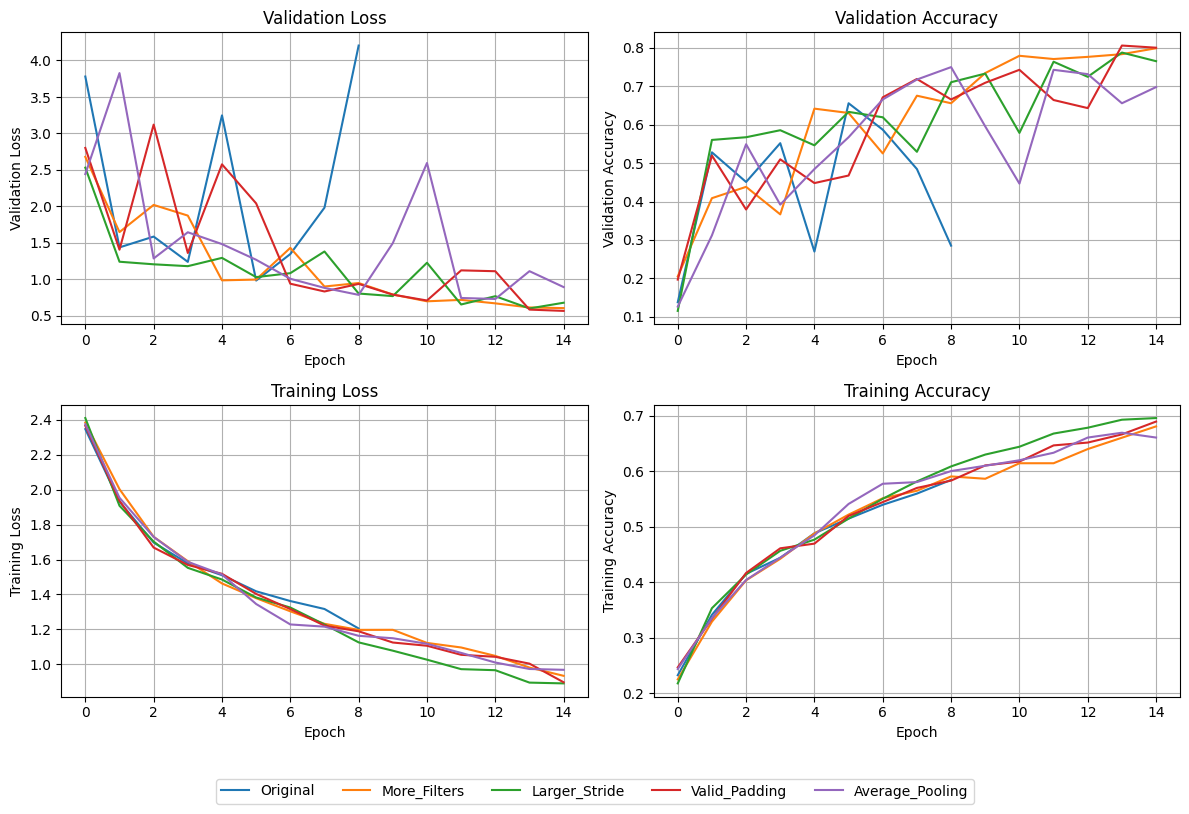

In [ ]:
# Define metric names and titles for subplots
metrics = [
    ('val_loss', 'Validation Loss'),
    ('val_accuracy', 'Validation Accuracy'),
    ('loss', 'Training Loss'),
    ('accuracy', 'Training Accuracy')
]

# Prepare figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

model_names = cnn_variants_params.keys()

for i, (metric_key, title) in enumerate(metrics):
    ax = axes[i]
    for j, name in enumerate(model_names):
        values = results[name].get(metric_key)
        if values:
            ax.plot(values, label=name)

    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.grid(True)

# Add a single legend below all plots
# Use bbox_to_anchor to place it outside the figure
fig.legend(model_names, loc='lower center', ncol=len(model_names), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at the bottom for the legend
plt.show()

##### Evaluation and final Comparision of the variants

In [ ]:
# Loop through each model and print the classification report
for name, model in models.items():
    print(f"\n=== Classification Report for {name} ===")

    # Predict probabilities or logits
    y_pred_prob = model.predict(X_test)

    # Convert predictions to class indices
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert one-hot test labels to class indices
    y_true = np.argmax(y_test, axis=1)

    # Decode integer labels back to original class names
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_true)

    # Print classification report with actual label names
    print(classification_report(y_true_labels, y_pred_labels, digits=4))


=== Classification Report for Original ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.7812    0.8621    0.8197        58
                 Cleavers     0.6970    0.5349    0.6053        43
         Common Chickweed     0.6947    0.9891    0.8161        92
             Common wheat     0.6154    0.2424    0.3478        33
                  Fat Hen     0.6923    0.2500    0.3673        72
         Loose Silky-bent     0.5429    0.9694    0.6960        98
                    Maize     0.5333    0.2424    0.3333        33
        Scentless Mayweed     0.5321    0.7436    0.6203        78
          Shepherds Purse     0.2500    0.0588    0.0952        34
Small-flowered Cranesbill     0.8553    0.8667    0.8609        75
               Sugar beet     0.6349    0.6897    0.6612        58

                 accuracy                   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.9138    0.9138    0.9138        58
                 Cleavers     0.9000    0.8372    0.8675        43
         Common Chickweed     0.9247    0.9348    0.9297        92
             Common wheat     0.7027    0.7879    0.7429        33
                  Fat Hen     0.9062    0.8056    0.8529        72
         Loose Silky-bent     0.6835    0.9694    0.8017        98
                    Maize     0.7333    0.6667    0.6984        33
        Scentless Mayweed     0.6667    0.8718    0.7556        78
          Shepherds Purse     0.7895    0.4412    0.5660        34
Small-flowered Cranesbill     0.9155    0.8667    0.8904        75
               Sugar beet     0.8333    0.8621    0.8475        58

                 accuracy                         0.8050       713
                macro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.8833    0.9138    0.8983        58
                 Cleavers     0.8636    0.8837    0.8736        43
         Common Chickweed     0.8600    0.9348    0.8958        92
             Common wheat     0.8000    0.7273    0.7619        33
                  Fat Hen     0.8788    0.8056    0.8406        72
         Loose Silky-bent     0.6503    0.9490    0.7718        98
                    Maize     0.6765    0.6970    0.6866        33
        Scentless Mayweed     0.7097    0.8462    0.7719        78
          Shepherds Purse     0.6667    0.2941    0.4082        34
Small-flowered Cranesbill     0.8421    0.8533    0.8477        75
               Sugar beet     0.8846    0.7931    0.8364        58

                 accuracy                         0.7868       713
                macro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.9216    0.8103    0.8624        58
                 Cleavers     0.7609    0.8140    0.7865        43
         Common Chickweed     0.8878    0.9457    0.9158        92
             Common wheat     0.7222    0.7879    0.7536        33
                  Fat Hen     0.7368    0.7778    0.7568        72
         Loose Silky-bent     0.6528    0.9592    0.7769        98
                    Maize     0.7333    0.6667    0.6984        33
        Scentless Mayweed     0.7033    0.8205    0.7574        78
          Shepherds Purse     0.8333    0.4412    0.5769        34
Small-flowered Cranesbill     0.9692    0.8400    0.9000        75
               Sugar beet     0.8103    0.8103    0.8103        58

                 accuracy                         0.7798       713
                macro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.8667    0.8966    0.8814        58
                 Cleavers     0.8684    0.7674    0.8148        43
         Common Chickweed     0.6977    0.9783    0.8145        92
             Common wheat     0.6000    0.3636    0.4528        33
                  Fat Hen     0.9250    0.5139    0.6607        72
         Loose Silky-bent     0.5556    0.9694    0.7063        98
                    Maize     0.7778    0.6364    0.7000        33
        Scentless Mayweed     0.6867    0.7308    0.7081        78
          Shepherds Purse     0.5625    0.2647    0.3600        34
Small-flowered Cranesbill     0.9014    0.8533    0.8767        75
               Sugar beet     0.8621    0.8621    0.8621        58

                 accuracy                         0.7293       713
                macro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Conclusions
After looking at the performance of all these variants, the conclusions we can get are:
1. The biggest problem in all models is the complete failure to classify the *Black-grass* class correctly. This problem will be address later with the use of a focused Data Agumentation.
2. The *More_Filters* is the model that achieves the highest accuracy (80%) and F1-score across nearly every class. This performance suggests that increasing the number of filters allows the model to capture more features/details.
3. Both *Larger_Stride* and *Valid_Padding* models come close to the performance of *More_Filters*. While Larger_Strides doesn't have the same performance of *More_Filters*, it offers a good trade-off since it benefit of a reduced training time and a inference speed, because it reduces the feature map resolution. From this aspect we can't say the same of Valid_Padding that has the longest training time.
4. The *Average_Pooling* model provides moderate results, better than the *Original*,but still behind the other models. This could suggest that while average pooling may help reduce noise, it might also suppress fine-grained spatial features useful for distinguishing some plant classes.

#### CNN Model Improvement
After experimented the performance of the CNNs variants, we tried to build/train a better model, using the consideration we did before. So we defined another configuration for improving our model.

##### Training

In [ ]:
cnn_improved_params = {
    # convolutional Layers
    'filters': [32, 64, 128, 128],
    'kernel_size': (3, 3),
    'conv_activation': 'relu',
    'padding': 'same',

    # Pooling
    'pooling': 'max',
    'pool_size': (2, 2),
    'pool_stride': 2,

    # batch Normalization
    'use_batchnorm': True,

    # Dense layers
    'dense_layers': [512, 256, 128],
    'dense_activation': 'relu',
    'dropout_rate': 0.3,

    # Output layer
    'final_activation': 'softmax'
}

model_path = os.path.join(base_dir, "models/cnn_improved.h5")
history_path = os.path.join(base_dir, "histories/history_cnn_improved.json")

print(f"Building the improved model...")
cnn_improved = build_custom_cnn(
    input_shape=X_train.shape[1:],
    num_classes=y_train.shape[1],
    **cnn_improved_params
)

cnn_improved.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True,
                            verbose=1 )
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=3,
                            min_lr=1e-6, verbose=1 )

cnn_improved_history = cnn_improved.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)

# Save model and training artifacts
cnn_improved.save(model_path)
with open(history_path, 'w') as f:
    json.dump(cnn_improved_history.history, f)

cnn_improved_history = cnn_improved_history.history

Building the improved model...
Epoch 1/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.1720 - loss: 2.6660 - precision_1: 0.2391 - recall_1: 0.0482 - val_accuracy: 0.2022 - val_loss: 2.2494 - val_precision_1: 0.5200 - val_recall_1: 0.1278 - learning_rate: 0.0010
Epoch 2/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3501 - loss: 1.9259 - precision_1: 0.5338 - recall_1: 0.1653 - val_accuracy: 0.2809 - val_loss: 4.6329 - val_precision_1: 0.2828 - val_recall_1: 0.2303 - learning_rate: 0.0010
Epoch 3/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4465 - loss: 1.6441 - precision_1: 0.5992 - recall_1: 0.2470 - val_accuracy: 0.5801 - val_loss: 1.2343 - val_precision_1: 0.6808 - val_recall_1: 0.4522 - learning_rate: 0.0010
Epoch 4/50
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4742 - loss: 1.5086 - precision_1: 0.6361 - recall_1: 0.2931 - val_accuracy: 0.4860 - val_loss: 1.5348 - val_precision_1: 0.6239 - val_recall_1: 0.3890 - learning_rate: 0.001

##### Evaluation

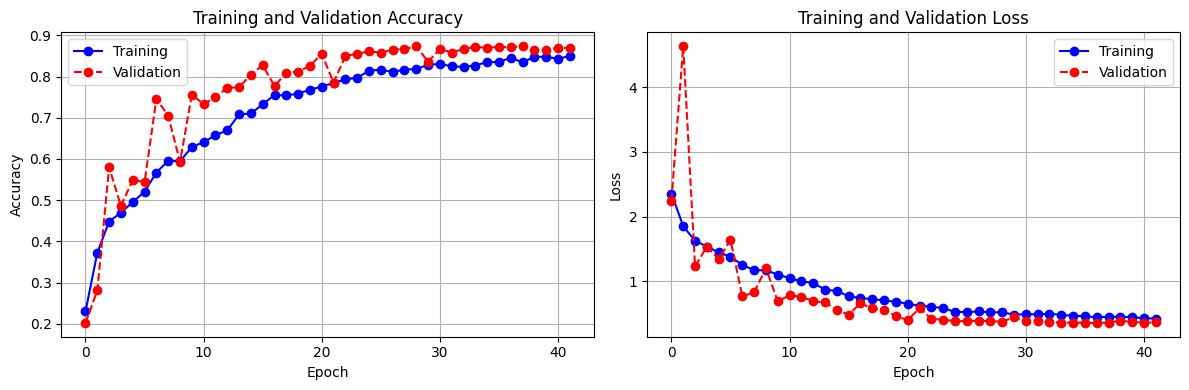

In [ ]:
print_learning_curves(cnn_improved_history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

                           precision    recall  f1-score   support

              Black-grass     0.0000    0.0000    0.0000        39
                 Charlock     0.9804    0.8621    0.9174        58
                 Cleavers     0.8864    0.9070    0.8966        43
         Common Chickweed     0.9574    0.9783    0.9677        92
             Common wheat     0.7750    0.9394    0.8493        33
                  Fat Hen     0.9242    0.8472    0.8841        72
         Loose Silky-bent     0.7068    0.9592    0.8139        98
                    Maize     0.6923    0.8182    0.7500        33
        Scentless Mayweed     0.8046    0.8974    0.8485        78
          Shepherds Purse     0.8000    0.5882    0.6780        34
Small-flowered Cranesbill     0.9000    0.9600    0.9290        75
               Sugar beet     0.9259    0.8621    0.8929        58

                 accuracy                         0.8471       713
                macro avg     0.7794    0.8016    0.7856    

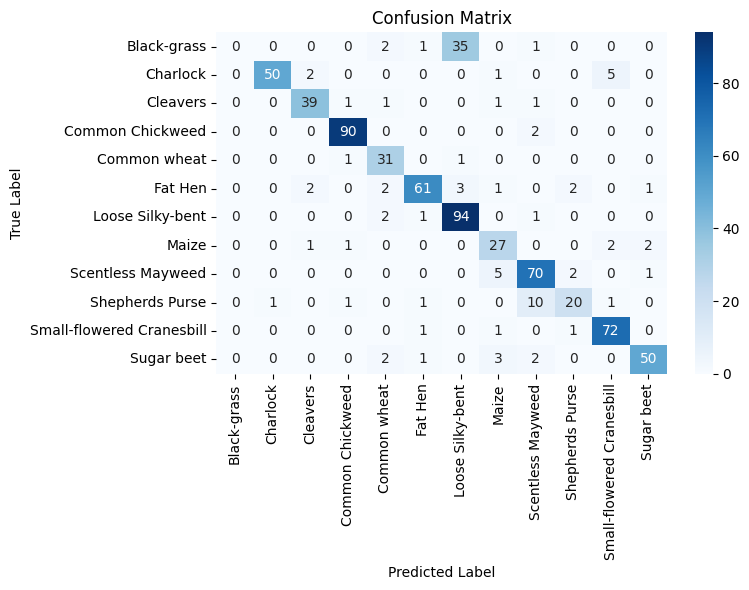

In [ ]:
print_classification_report_and_matrix(cnn_improved, os.path.join(base_dir, "reports/cnn_improved"))

##### Conclusions:
This improved model performed better than all the other variants examined in the previous section, but it still had the problem of the complete failure of classifying the Black-grass. Particularly, plotting the confusion matrix, we saw that the most of the *Black-grass* samples were classified as *Loose Silky-Bent*. Probably the model sees features in Black-grass samples that are more similar to what it learned from Loose Silky-Bent samples.

#### Impact of Data Agumentation
Since the previous model had difficulty distinguishing between *Black-grass* and *Loose Silky-Bent*, we decided to apply a focused Data augmentation in order to help the model generalize better on these classes. Specifically, to implement it in the training procedure, we followed these steps:
1. We converted again in integers the one-hot encoded labels.
2.	We splitted the training data into three groups, two with the classes of interest (Black-grass and Loose Silky-bent) and a group containing all other classes. We did this because we planned to apply a different augmentation strategies to these different subsets.
3. We defined two Data Agumentation Strategies:
    - **Strong augmentation** for the challenging classes, in order to increase their variation.
    - **Light augmentation** for all the other classes to slightly enhance diversity, but without overfitting.
4. A custom Data Generator was defined to yield mixed batches containing the strongly augmented samples from the two targeted classes and the lightly augmented samples from the rest. This exposed the model on a greater variety of the challenging classes, letting it focusing and learning more from them (it could be considered also a solution for imbalance problems)

In [ ]:
# 1. prepare Label Indexes
# Convert one-hot to class indices
y_train_labels = np.argmax(y_train, axis=1)

# Set class indices (adjust if needed)
blackgrass_class_index = 0
loose_silky_class_index = 6

idx_blackgrass = np.where(y_train_labels == blackgrass_class_index)[0]
idx_loose_silky = np.where(y_train_labels == loose_silky_class_index)[0]
idx_others = np.where((y_train_labels != blackgrass_class_index) &
                      (y_train_labels != loose_silky_class_index))[0]

# 2. Splitting the dataset in three parts:
# Blackgrass dataset
X_blackgrass = X_train[idx_blackgrass]
y_blackgrass = y_train[idx_blackgrass]

# Loose Silky Bent dataset
X_loose_silky = X_train[idx_loose_silky]
y_loose_silky = y_train[idx_loose_silky]

# Other plants dataset (everything else)
X_others = X_train[idx_others]
y_others = y_train[idx_others]

# 3. Data Augmentation Strategies
# Strong agumentation for Blackgrass and Loose Silky Bent
strong_aug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=[0.6, 1.4],
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.5],
    shear_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Light augmentation for other plants
light_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

#strong_aug.fit(X_blackgrass)
#strong_aug.fit(X_loose_silky)
#light_aug.fit(X_others)

# 4. Custom batch generator that combines the three datasets
def combined_generator():
    gen_black = strong_aug.flow(X_blackgrass, y_blackgrass, batch_size=4, seed=42)
    gen_silky = strong_aug.flow(X_loose_silky, y_loose_silky, batch_size=4, seed=42)
    gen_other = light_aug.flow(X_others, y_others, batch_size=16, seed=42)

    while True:
        xb = next(gen_black)
        xs = next(gen_silky)
        xo = next(gen_other)

        X_batch = np.concatenate([xb[0], xs[0], xo[0]])
        y_batch = np.concatenate([xb[1], xs[1], xo[1]])

        idx = np.arange(len(X_batch))
        np.random.shuffle(idx)

        yield X_batch[idx], y_batch[idx]

model_path = os.path.join(base_dir, "models/cnn_data_agumentation.h5")
history_path = os.path.join(base_dir, "histories/history_cnn_data_agumentation.json")

print(f"Building the improved model...")
cnn_data_agumentation = build_custom_cnn(
    input_shape=X_train.shape[1:],
    num_classes=y_train.shape[1],
    **cnn_improved_params
)

cnn_data_agumentation.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping( monitor='val_loss', patience=6, restore_best_weights=True,
                            verbose=1 )
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=3,
                                min_lr=1e-6, verbose=1 )

# In this case, we defined steps_per_epoch as the number of batches per epoch, intead of
# specifying the batch size directly.
# This is because the combined generator yields batches of data, and we want to control how many batches
# we process in each epoch.
steps_per_epoch = len(X_train) // 24

cnn_data_agumentation_history = cnn_data_agumentation.fit(
    combined_generator(),
    validation_data=(X_val, y_val),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    #batch_size=8,
    callbacks=[early_stop, reduce_lr]
)

# Save model and training artifacts
cnn_data_agumentation.save(model_path)
with open(history_path, 'w') as f:
    json.dump(cnn_data_agumentation_history.history, f)

cnn_data_agumentation_history = cnn_data_agumentation_history.history

Building the improved model...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.2564 - loss: 2.3000 - precision_8: 0.3981 - recall_8: 0.1264 - val_accuracy: 0.1376 - val_loss: 17.5464 - val_precision_8: 0.1376 - val_recall_8: 0.1376 - learning_rate: 0.0010
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.4213 - loss: 1.5371 - precision_8: 0.5154 - recall_8: 0.2709 - val_accuracy: 0.1376 - val_loss: 13.7678 - val_precision_8: 0.1376 - val_recall_8: 0.1376 - learning_rate: 0.0010
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.4995 - loss: 1.2883 - precision_8: 0.5829 - recall_8: 0.3675 - val_accuracy: 0.0829 - val_loss: 10.0984 - val_precision_8: 0.0837 - val_recall_8: 0.0829 - learning_rate: 0.0010
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.5460 - loss: 1.1518 - precision_8: 0.6055 - recall_8: 0.4231 - val_accuracy: 0.3048 - val_loss: 2.3699 - val_precision_8: 0.3301 - val_recall_8: 0.2402 - learning_r

##### Evaluation

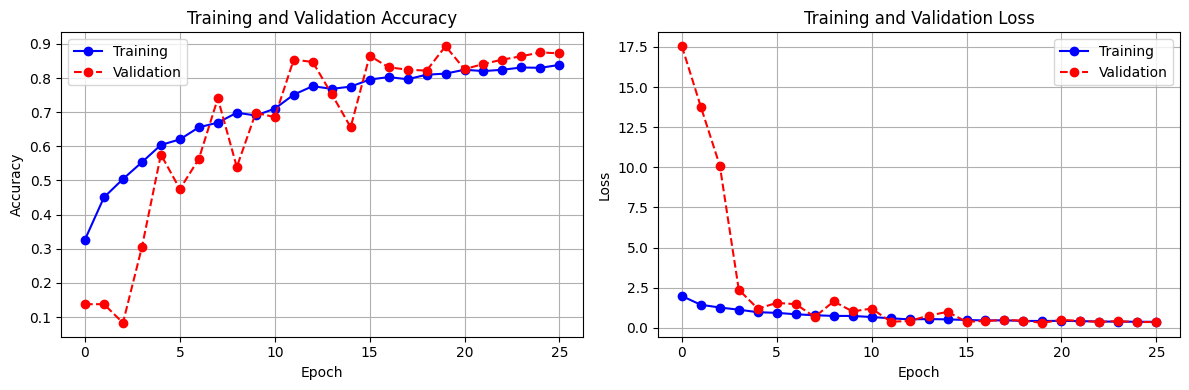

In [ ]:
print_learning_curves(cnn_data_agumentation_history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
                           precision    recall  f1-score   support

              Black-grass     0.5227    0.5897    0.5542        39
                 Charlock     0.9643    0.9310    0.9474        58
                 Cleavers     0.9500    0.8837    0.9157        43
         Common Chickweed     0.9674    0.9674    0.9674        92
             Common wheat     0.7778    0.8485    0.8116        33
                  Fat Hen     0.9839    0.8472    0.9104        72
         Loose Silky-bent     0.8280    0.7857    0.8063        98
                    Maize     0.6346    1.0000    0.7765        33
        Scentless Mayweed     0.8519    0.8846    0.8679        78
          Shepherds Purse     0.9286    0.7647    0.8387        34
Small-flowered Cranesbill     0.9865    0.9733    0.9799        75
               Sugar beet     0.9455    0.8966    0.9204        58

                 accuracy                         0.8738       713
                macr

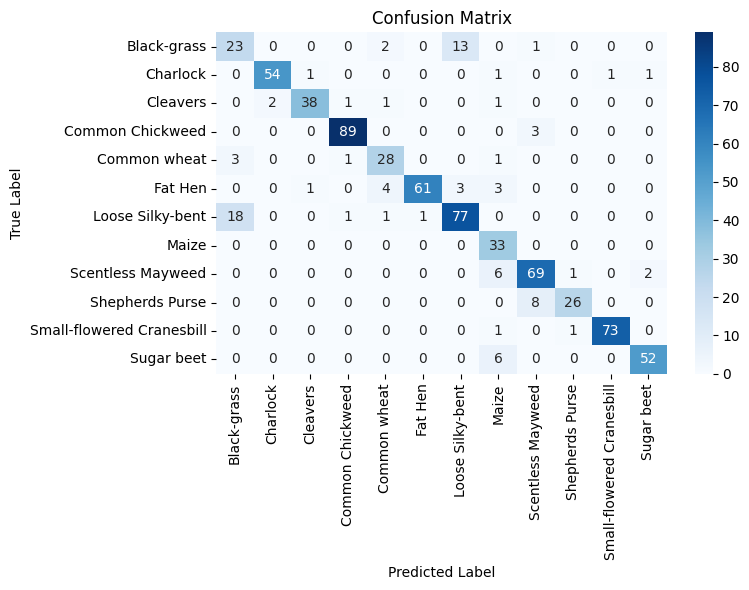

In [ ]:
print_classification_report_and_matrix(cnn_data_agumentation, os.path.join(base_dir, "reports/cnn_data_agumentation"))

##### Conclusions:
We can conclude that data augmentation almost solved the misclassification problem. By exposing the model to more diverse and varied versions of *Black-grass* samples (such as orientation changes, scale, exc.), the model developed a more robust and generalized understanding of what *Black-grass* and *Loose Silky-bent* really looks like. So it became more sensitive to the characteristics that distinguish the two classes.

Unfortunately, we have more Loose Silky-bent samples misclassified, but the Precision and the Recall on this class are still high. We can say that it is also a matter of **trading-off** between the performance of Loose Silky-bent and Black-grass because they are very similar.

#### Convolution Illustration
To show a convolution Operation on one Convolutional Layer, we loaded one model saved before and created another model meant just to perform a convolution Operation. 

We selected the second convolution layer in our CNN, it's easy to change to another layer. The layer we choose had a resolution of the feature maps is 48×48, which was smaller than the initial input. This reduction in resolution allows the convolution to focus on higher-level patterns rather than fine-grained pixel details. 
We showed just the first 15 filters; each one captured a different feature in the image. Indeed we can observe a variety of patterns being highlighted across these filters, such as:
- **Edge and Shape Detection**: some filters appear to be detecting edges or parts of shapes. For instance, filter 0 and 2 seem to be highlighting the elongated shape of the seedling, possibly picking up on its outline.
- **Pattern Recognition**: Other filters might be responding to specific textures or patterns within the seedling. Some filters show brighter regions in what appears to be the center of the seedling, suggesting they might be identifying internal structures or specific intensity variations.
- **Directional Features**: Some filters might be specialized in detecting features oriented in specific directions.

First ten layers of the model:
0 conv2d_3 (None, 96, 96, 32)
1 batch_normalization_6 (None, 96, 96, 32)
2 max_pooling2d_3 (None, 48, 48, 32)
3 conv2d_4 (None, 48, 48, 64)
4 batch_normalization_7 (None, 48, 48, 64)
5 max_pooling2d_4 (None, 24, 24, 64)
6 conv2d_5 (None, 24, 24, 128)
7 batch_normalization_8 (None, 24, 24, 128)
8 max_pooling2d_5 (None, 12, 12, 128)
9 flatten_1 (None, 18432)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


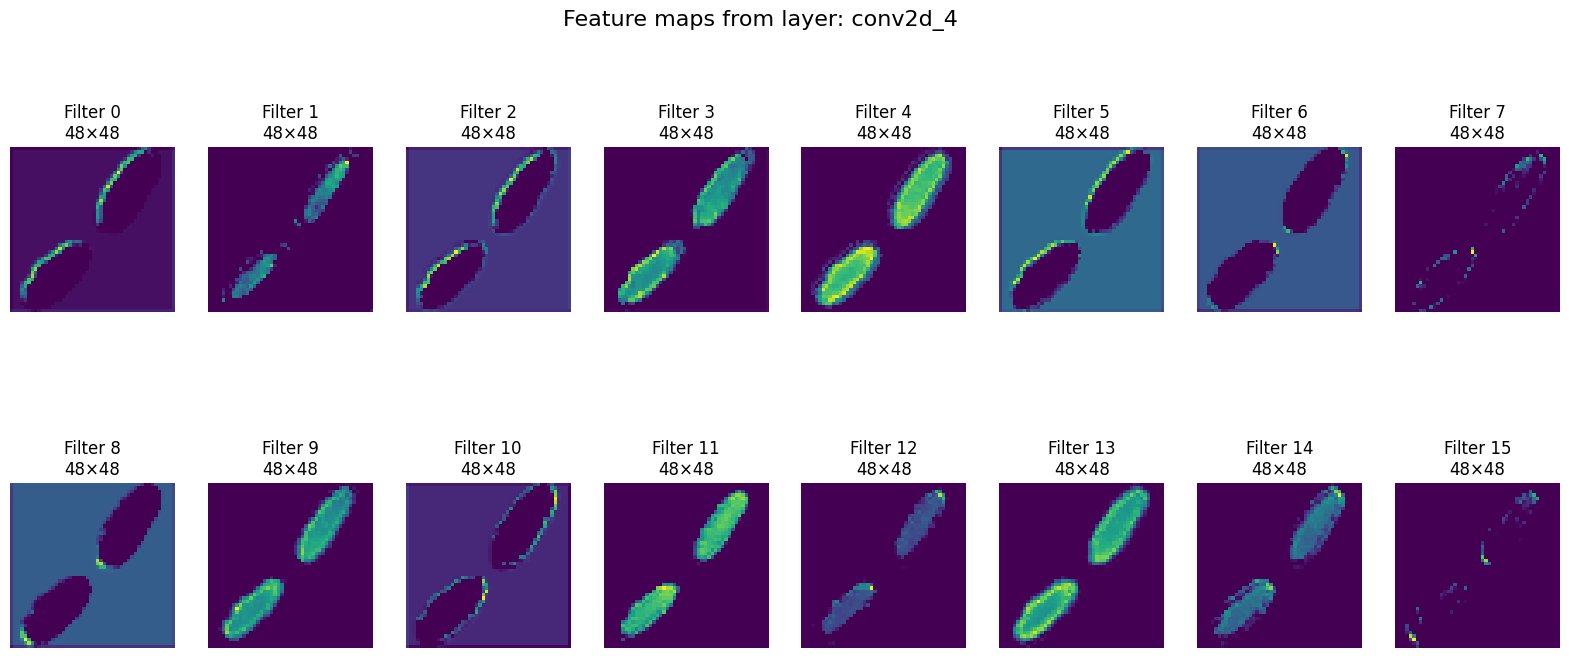

In [12]:
# Retrieve the model
model_example = load_model(os.path.join(base_dir, "models/Original.h5"))

# Printing first ten layers of the model
print("First ten layers of the model:")
for i in range(10):
    layer = model_example.layers[i]
    print(i, layer.name, layer.output.shape)

# Building a model that will just output the feature maps of a specific convolutional layer
layer_to_visualize = model_example.layers[3]                    # Layer to visualize
layer_name = layer_to_visualize.name                            # Name of the layer
conv_layer_model = Model(inputs=model_example.layers[0].input,  # Model to visualize feature maps
                         outputs=layer_to_visualize.output)

# Get a sample image with which to visualize the feature maps
sample_image = X_val[0]
# Adding the batch dimension because the model expects input in the shape (batch_size, height, width, channels)
sample_image = np.expand_dims(sample_image, axis=0)

# Executing the convolution, which will return the feature maps
feature_maps = conv_layer_model.predict(sample_image)

# Plot the feature maps
num_filters = feature_maps.shape[-1]
size_h, size_w = feature_maps.shape[1], feature_maps.shape[2]

plt.figure(figsize=(20, 8))
for i in range(min(num_filters, 16)):  # Show first 16 filters
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i}\n{size_h}×{size_w}')
plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
plt.show()


#### CNN improvement using a Pretrained Model
*ResNet50* was utilized for this project to classify plant species like blackgrass and loose silky-bent because it is able to extract complex features from images. Indeed the residual architecture of ResNet allows for deep networks to be trained while minimizing residual gradient decay. 
Additionally, ResNet50 is pretrained on ImageNet, so it allows for the **transfer of visual knowledge**, perfect for this task. Furthermore it takes advantage of even a small dataset to increase the accuracy of the model. Rather than starting with the last layer of ResNet50, which would necessitate extensive data and time, we instead fine-tuned the last 30 layers of the ResNet50 model. This allowed us to remodel the architecture to keep the general applications of the pretrained layers, while having more specific relevant training on the final fine-tuned layers. 
In addition, models of this nature have a high level of efficiency, which allows for practical training without expansive computational costs.

In [ ]:
# --- Preprocess images for ResNet50 (expects 0-255 range) ---
X_train_resnet = preprocess_input(X_train * 255.0)
X_val_resnet = preprocess_input(X_val * 255.0)
X_test_resnet = preprocess_input(X_test * 255.0)

# Resplitting the dataset in the three parts, since now we have preprocessed images for ResNet50
X_blackgrass_resnet = X_train_resnet[idx_blackgrass]
X_loose_silky_resnet = X_train_resnet[idx_loose_silky]
X_others_resnet = X_train_resnet[idx_others]

# Generator for ResNet50
def combined_generator_resnet():
    gen_black = strong_aug.flow(X_blackgrass_resnet, y_blackgrass, batch_size=4, seed=42)
    gen_silky = strong_aug.flow(X_loose_silky_resnet, y_loose_silky, batch_size=4, seed=42)
    gen_other = light_aug.flow(X_others_resnet, y_others, batch_size=16, seed=42)

    while True:
        xb = next(gen_black)
        xs = next(gen_silky)
        xo = next(gen_other)

        X_batch = np.concatenate([xb[0], xs[0], xo[0]])
        y_batch = np.concatenate([xb[1], xs[1], xo[1]])

        idx = np.arange(len(X_batch))
        np.random.shuffle(idx)

        yield X_batch[idx], y_batch[idx]

# Build Transfer Learning Model with ResNet50
def build_resnet_model(input_shape, num_classes, base_trainable=False):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    #base_model.trainable = base_trainable

    for layer in base_model.layers[-30:]:
      layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Model definition
cnn_resnet = build_resnet_model(
    input_shape=X_train.shape[1:],
    num_classes=y_train.shape[1],
    base_trainable=False
)

cnn_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
steps_per_epoch = len(X_train) // 24

# Train the Model
cnn_resnet_history = cnn_resnet.fit(
    combined_generator_resnet(),
    validation_data=(X_val_resnet, y_val),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# Save model and training artifacts
model_path = os.path.join(base_dir, "models/cnn_resnet50.h5")
history_path = os.path.join(base_dir, "histories/history_cnn_resnet50.json")
cnn_resnet.save(model_path)
with open(history_path, 'w') as f:
    json.dump(cnn_resnet_history.history, f)
cnn_resnet_history = cnn_resnet_history.history

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


138/138 ━━━━━━━━━━━━━━━━━━━━ 109s 376ms/step - accuracy: 0.3748 - loss: 2.0694 - precision_1: 0.4713 - recall_1: 0.2195 - val_accuracy: 0.1278 - val_loss: 36.3661 - val_precision_1: 0.1278 - val_recall_1: 0.1278 - learning_rate: 0.0010
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.5794 - loss: 1.1592 - precision_1: 0.6505 - recall_1: 0.4729 - val_accuracy: 0.1503 - val_loss: 8.6746 - val_precision_1: 0.1522 - val_recall_1: 0.1503 - learning_rate: 0.0010
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.6517 - loss: 0.8742 - precision_1: 0.6994 - recall_1: 0.5722 - val_accuracy: 0.4930 - val_loss: 1.7682 - val_precision_1: 0.5211 - val_recall_1: 0.4340 - learning_rate: 0.0010
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.7076 - loss: 0.6892 - precision_1: 0.7439 - recall_1: 0.6559 - val_accuracy: 0.2823 - val_loss: 2.8772 - val_precision_1: 0.3114 - val_recall_1: 0.2528 - learning_rate: 0.0010
Epoch 5/50
138/138 ━━━━━━━━━━

##### Evaluation

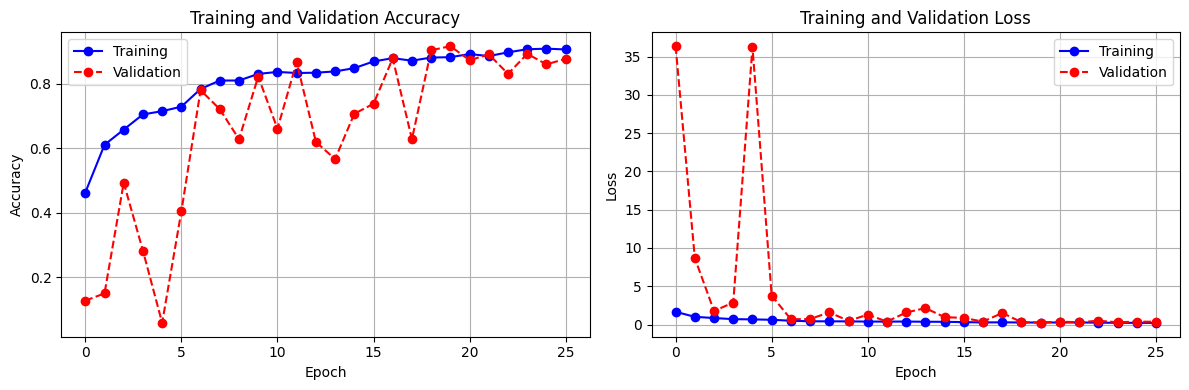

In [21]:
print_learning_curves(cnn_resnet_history)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step
                           precision    recall  f1-score   support

              Black-grass     0.6486    0.6154    0.6316        39
                 Charlock     0.9667    1.0000    0.9831        58
                 Cleavers     0.9512    0.9070    0.9286        43
         Common Chickweed     0.9677    0.9783    0.9730        92
             Common wheat     0.7619    0.9697    0.8533        33
                  Fat Hen     0.9571    0.9306    0.9437        72
         Loose Silky-bent     0.8632    0.8367    0.8497        98
                    Maize     0.8824    0.9091    0.8955        33
        Scentless Mayweed     0.9359    0.9359    0.9359        78
          Shepherds Purse     0.9688    0.9118    0.9394        34
Small-flowered Cranesbill     1.0000    0.9733    0.9865        75
               Sugar beet     0.9483    0.9483    0.9483        58

                 accuracy                         0.9173       713
                mac

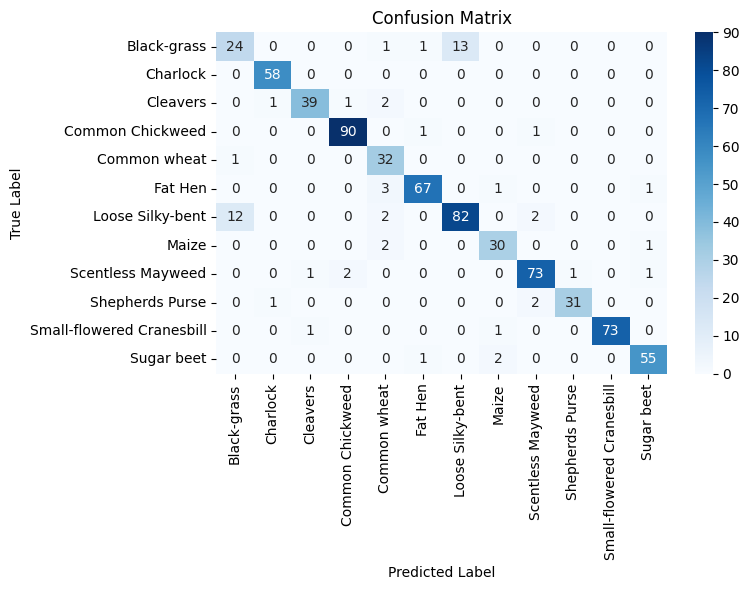

In [22]:
print_classification_report_and_matrix(cnn_resnet, X_test=X_test_resnet, y_test=y_test,
                                       save_path=os.path.join(base_dir, "reports/cnn_resnet50"))

##### Conclusions
The fine-tuned model demonstrated significantly improved performance compared to the CNN we trained autonomously. Indeed with its deeper architecture and pretrained weights, the model was able to learn more robust and discriminative features of images. Additional it got better performance also in recognizing between Black-grass and Loose Silky-bent, likely due to its greater capacity to capture visual differences.

In [3]:
best_model = load_model(os.path.join(base_dir, "models/cnn_data_agumentation.h5"))
best_model = load_model(os.path.join(base_dir, "models/cnn_resnet50.h5"))
best_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 4608)           │        18,432 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,789,326 (10.64 MB)

 Trainable params: 2,777,868 (10.60 MB)

 Non-trainable params: 11,456 (44.75 KB)

 Optimizer params: 2 (12.00 B)